# Introduction to Neural Networks with Pytorch

This primer assumes familiarity with the concept and theory behind neural networks and are ready to start exploring how Pytorch facilitates their implementation.

In [ ]:
# start time - notebook execution
import time
start_nb = time.time()

# Getting Pytorch Going

Let's get started by importing pytorch and some of the more important sub-modules.

In [ ]:
import torch                     # pytorch
import torch.nn as nn            # pytorch neural network sub-library
import torch.optim as optim      # pytorch optimizers
import matplotlib.pyplot as plt  # plotting
import numpy
import random                    # random number generators

# This will allow visualization of the neural network structure
!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot

# Initialize the Autograder

In [ ]:
''' placeholder function to satisfy auto-grader dependency '''
def make_data(x):
    pass

# import the autograder tests
import hw1_tests as ag

# Generate a data set

Before we start, we need a dataset. We could grab a dataset off the internet but we might not understand the nuances of the data very well. Instead, we will generate some data and then train on it.

Let's pretend we are building a self-driving car. The car has proximity sensor and can act on that sensor information: it can accelerate or break, and it can turn the steering wheel left or right. Based on values from the proximity sensors, we want to infer how much energy to apply to the accelerator or breaks and how much to turn the steering wheel.

Let's further assume that we have also put sensors on human driver's cars and we have been recording the data from the proximity sensors and also recording how much the human drivers press the accelerator or breaks and turn the wheel. This is called a *supervised learning* task. For every set of recorded sensor data, we know what a human has really done in response. Now all we need to do is train a neural network to produce the known-correct response when given a set of sensor data. If our model is good enough, we will trust it to make decisions on the car in situations that it has never seen before.

What we are going to do here is synthetically generate the data set. Let's assume the car has 4 sensor:
* proximity to car in front (0...1)
* proximity to car in back (0...1)
* proximity to car to the left (0...1)
* proximity to car in on the right (0...1)

We will randomly generate this data.

We also need a supervisions signal: what the car should do under different circumstances. I have provided some simple rules for how the car should behave. This is a bit artificial--why do we need a neural network to drive the car if I know what the rules are and can write the code for those rules? In reality we wouldn't have these rules, but for learning pytorch we need a ground-truth of non-random supervision. So we will pretend that we acquired behavioral data for the car.

There are 2 controls for the car:
* accelerate: how much should we accelerate (-1...1)? Negative values means braking
* turn: how much should we turn the steering wheel (-1...1)? Negative means left, positive means right.

**Read through the code so that you understand how the data will be generated.**

Normally we will not have a known function that generates data for us. Instead we will inspect the data and get to know it so we can make design decisions. However, since this is a warm-up activity, we will be able to see the normally impossible-to-know source of the data.


In [ ]:
def make_data(num_data):
  data = [] # aggregate the data here

  for n in range(num_data):
    # Generate a random state
    # the distance to the nearest car in front/back/left/right is normalized from 0.0 (closest) to 1.0 (farthest)
    carInFrontDist = random.random()
    carInBackDist = random.random()
    carLeftDist = random.random()
    carRightDist = random.random()

    # Response to the state. 1 =  brakes/accelerator/steer-left/steer-right is activated. 0=not activated
    # Though binary, we will be using numbers
    accel = 1.0
    turn = 0.0

    # Should I accelerate or brake?
    if carInFrontDist < 0.50:
      # Car is close, brake
      # Unless there is another car close behind
      if carInBackDist > 0.50:
        # Okay to brake
        accel = -carInFrontDist/0.50
      else:
        # Not okay to brake, but at least stop accelerating
        accel = 0
    else:
      # Car in front is not close, continue to accelerate
      accel = (carInFrontDist - 0.50)/0.50

    # Should I turn left or right? (can't do both)
    if carLeftDist < 0.5 or carRightDist < 0.5:
      turn = (1.0 - (carLeftDist)) - (1.0 - carRightDist)

    # Store the data
    x = (carInFrontDist, carInBackDist, carLeftDist, carRightDist)
    y = (accel, turn)
    data.append((x, y))
  return data

In [ ]:
train_data = make_data(10000)

Let's take a look at the data. There is a lot, so let's just look at one data element.



In [ ]:
train_data[0]

In [ ]:
train_data[0:3][0]

The data is an array. Each element is a tuple. The first element in the tuple is the input data (*x*), which contains the four sensor inputs. The second element in the tuple is the output data (*y*), the correct behavior of the car in response to the sensor inputs.

# Data Preparation

We need to do two things. First, we need to convert our data into tensors, which are the array-like data structures that Pytorch uses. Fortunately, it is easy to create tensors from arrays and tuples. Use ```torch.tensor()```, which can accept any array, tuple, or array-like data structure from ```numpy```.

Second, we need to group chunks of data into batches. A batch is a chunk of data that can be run through the neural network in parallel. This greatly speeds up the training of the neural network and has some other advantages as well.

**Complete the following function**.

The function will get a chunk of data and convert it into tensors. The input parameters to the function are:
* ```data```: the entire dataset in the form of a list of tuples where each tuple is ```((input_feature_1, ... input_feature_n), (output_feature1, ..., output_feature_m))```.
* ```batch_size```: number of input/output pairs to collect together.
* ```index```: the $n$th batch. That is, the 0th batch will be elements from ```data``` with indexes ```[0 ... batch_size)```. The 1st batch will be elements from ```data``` with indexes ```[batch_size ... batch_size*2)```. The 2nd batch will be the elements with indexes ```[batch_size*2 ... batch_size*3)``` and so on.

It will return two values:
* a tensor containing ```batch_size``` input examples (*x*). The tensor should be a 2D tensor of shape ```batch_size x input_features```.
* a tensor containing ```batch_size``` output examples (*y*). The tensor should be a 2D tensor or shape ```batch_size x output_features```.

In doing so we are splitting out the inputs from the outputs.




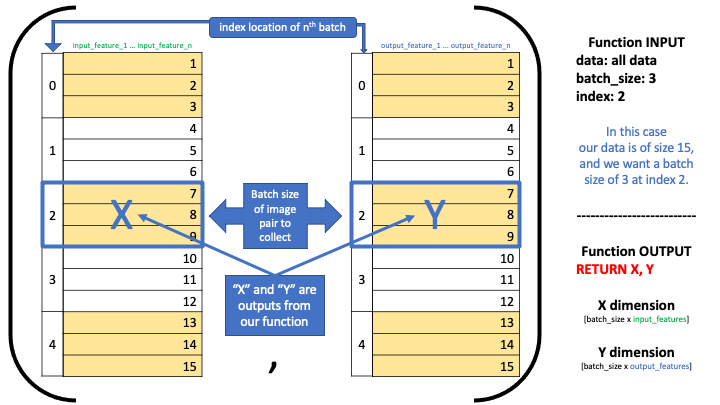

## Part A

Write the ```get_batch()``` function below. This function takes a dataset and a batch size and returns a batch of data from the dataset. The batch should be a tuple of tensors.

**Hints**
- The first tensor should be the inputs and the second tensor should be the outputs.
- The inputs should be a tensor of size ```batch_size x 4``` and the outputs should be a tensor of size ```batch_size x 2```.
- The inputs should be the first four values in each tuple in the dataset and the outputs should be the last two values in each tuple in the dataset.

In [ ]:
def get_batch(data, batch_size, index):
  x = None
  y = None
  ### BEGIN SOLUTION
  full_batch = data[batch_size*index:batch_size*(index+1)]
  x = torch.tensor([elem[0] for elem in full_batch])
  y = torch.tensor([elem[1] for elem in full_batch])
  ### END SOLUTION
  return x, y

Let's look a bit more closely at a batch.

In [ ]:
x, y = get_batch(train_data, 8, 0)

print('x:')
print(x)
print('shape of x:', x.size(),'\n')
print('y:')
print(y)
print('shape of y:', y.size())

The first row of the *x* tensor should look like the first part of the training data tuple at index 0 above. Each row in the tensor is the input portion of a different line of data. It has been merged into what looks like a multi-dimensional array.

The array has a particular *shape*. In particular it is an 8 x 4 array. The first dimension is for batching (there are 8 data points in the batch). The second dimension reveals that each data point has four values making it up.

The first row of the *y* tensor matches the second part of the training data tuple at index 0 above. The *y* tensor is an 8 x 2 array because there are eight data points, each consisting of two controls for the car.

## Part A (40 Points)
Unit test for the ```get_batch()``` function

In [ ]:
# student check
ag.PART_A()

# The Neural Network

Next we need to define the neural network. In pytorch we do this by creating a new class that sub-classes from ```nn.Module```. In this class we will define the different layers and indicate how the layers go together so that inputs flow through the layers to create outputs.

There are two functions that are essential in creating a pytorch neural network. The **constructor** creates the layers of the network as modules. What is strange at first is that there are no specifications in the constructor as to how the layers are connected. That is done below...

The **forward function** determines how the inputs are fed into the first layer and how the outputs of each each layer feed into the subsequent layers. The forward function returns the predicted output. In doing so, the tensors that get created and passed around will remember which modules computed them.

**Complete the constructor and forward function below**

The neural network you create should contain three `tanh` layers. The input layer has 4 neurons (one for each input feature in the data). The second layer should have 16 neurons and a `tanh` activation function. The third layer should have 8 neurons and a `tanh` activation function. The output layer should have two neurons (one for each output feature in the data) and `tanh` activation function to ensure the results are between -1.0 and 1.0.

Conventional layers in neural networks are created with alternating ```nn.Linear()``` and ```nn.Tanh()``` modules. A ```nn.Linear()``` module creates an affine transformation of a number of inputs from one layer to a different number of outputs at the next layer, implementing the function ```Ax + b``` where ```A``` is a set of weights applied to the input ```x``` and ```b``` is the bias. That is, if we have one layer that has 100 elements and we want to perform an affine transformation on those elements into a set of 200 elements, we would use ```nn.Linear(100, 200)```. The weights in ```A``` and ```b``` are held inside the module so we never have to directly involve ourselves with the weights.

## Part B

Write the ```CarNet``` class below. This class should sub-class from ```nn.Module```.

**Hints**
- The constructor should create the layers of the network as modules.
- The forward function should determine how the inputs are fed into the first layer and how the outputs of each each layer feed into the subsequent layers.
- The forward function should return the predicted output. In doing so, the tensors that get created and passed around will remember which modules computed them.

In [ ]:
class CarNet(nn.Module):

  def __init__(self):
    # Call the parent class constructor
    super(CarNet, self).__init__()
    ### BEGIN SOLUTION
    self.linear1 = nn.Linear(4, 16)
    self.tanh2 = nn.Tanh()
    self.linear3 = nn.Linear(16, 8)
    self.tanh4 = nn.Tanh()
    self.linear5 = nn.Linear(8, 2)
    self.tanh6 = nn.Tanh()
    ### END SOLUTION

  def forward(self, x):
    # x is the input tensor. Produce the predicted output y_hat
    y_hat = None
    ### BEGIN SOLUTION
    inter1 = self.linear1(x)
    inter2 = self.tanh2(inter1)
    inter3 = self.linear3(inter2)
    inter4 = self.tanh4(inter3)
    inter5 = self.linear5(inter4)
    y_hat = self.tanh6(inter5)
    ### END SOLUTION
    return y_hat

Let's now make a ```CarNet``` object:

In [ ]:
net = CarNet()
print(net)

You can go to the BOTTOM and run tests (**Part B Autograder**) on your network to make sure it is correct before proceeding.

Now that you have a neural network with all the correctly configured components inside, let's see how to run your neural network.

In [ ]:
# Get a batch
x, y = get_batch(train_data, 8, 0)
y_hat = net(x)

When we call the net object as if it were a function, pytorch knows to call the `forward()` function. As tensors are passed through the various layers, the tensors keep track of the modules that changed them and how they were changed. This creates a computation graph behind the scenes. Here is what the computation graph should look like for your network. These are the function names, and any python module may invoke more than one function that transforms a tensor. Can you identify which functions come from your activation function and which ones come from your linear layer? Weight matrices are also present in the graph, can you find them?

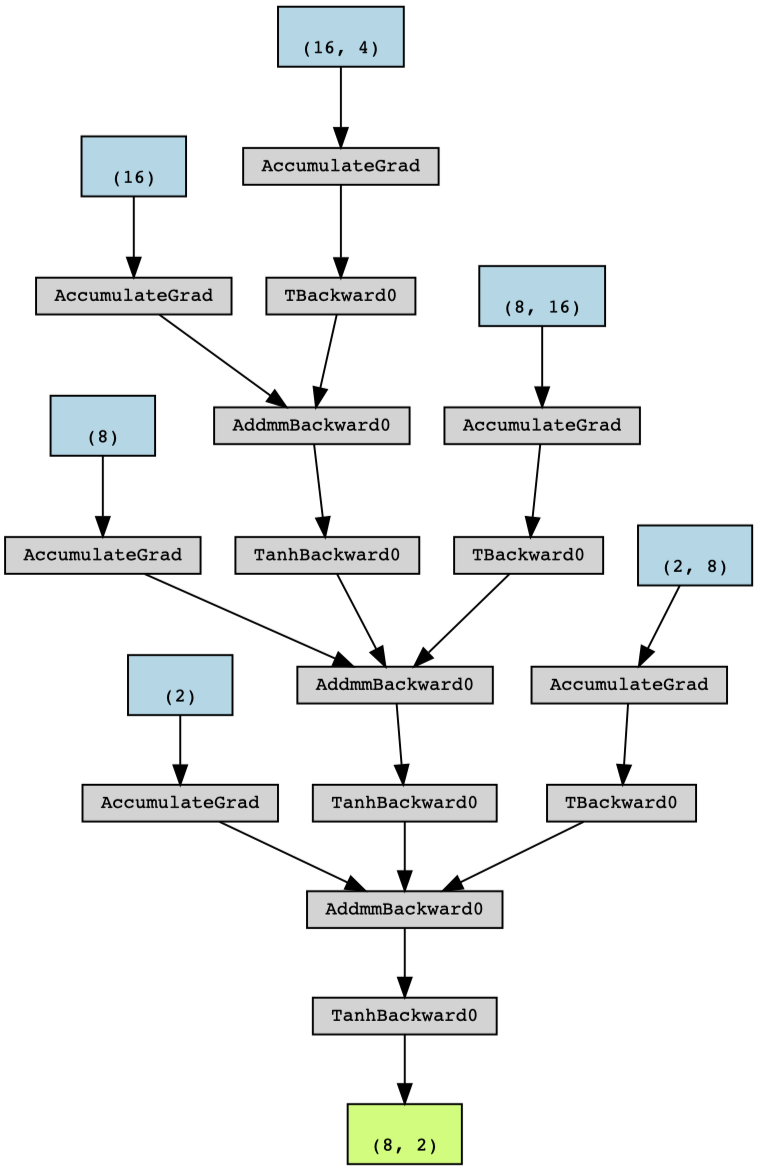


Now, let's look at your computation graph. They should be the **same**.

In [ ]:
make_dot(y_hat, params=dict(net.named_parameters()))

Let's look at the weights and gradients.

In [ ]:
for i, param in enumerate(net.parameters()):
  print('Parameter', i)
  print(param)
  print('shape:', param.size(), '\n')

The first tensor has a 16 x 4 shape because it stores the weights inside ```linear1```, which is fully connecting the 4 input values to 16 hidden nodes. A fully-connected layer going from 4 inputs to 16 hidden nodes would have 64 weights, and that is what we see.

The second tensor is 16 x 1. These are the bias weights inside ```linear1``` that are applied after the 4 inputs are multiplied by the weights in the prior tensor (Remember an affine transformation is $Ax + b$ where $A$ is a matrix of weights and $b$ is another matrix of weights for the bias).

The third tensor is 8 x 16 because these are the weights connecting the layer of 16 hidden notes to the layer of 8 hidden nodes. The fourth tensor is the 8 bias weights.

The fifth and sixth tensors fully connect the eight hidden nodes to the two outputs values and apply bias weights.

The activation functions don't have weights. They just apply their non-linear function to whatever inputs are passed in, regardless of size or shape.

# The Optimizer

Now we have a neural network. Running the network's forward pass will construct the network. Then we will want to backpropagate a loss signal. There are a lot of different optimization functions. We have to pick one and instantiate it.

We will use an optimization function called ```Adam``` and tell it about the parameters of our neural network. Since the CarNet class is just a wrapper, we must pass in parameters themselves---the weights.

In [ ]:
optimizer = optim.Adam(net.parameters())

To optimize, we also need to be able to calculate the network's loss. In this case we will use Mean Square Error.

In [ ]:
loss_fn = nn.MSELoss()

# Forward Pass

To run the neural net, you call the network class object (CarNet) as if it were a function and pass in the inputs. This automatically calls the ```forward()``` function.

Calling the neural network's forward function produces the predicted output, which we will save in ```y_hat``` to denote that it is a prediction and may not be accurate. (Indeed it won't be accurate because we haven't done any training yet.)

In [ ]:
# Get a batch
x, y = get_batch(train_data, 8, 0)

# Call the forward pass
y_hat = net(x)

Let's take a look at what the output looks like:

In [ ]:
print(y_hat)
print('Shape of y_hat:', y_hat.size())

The output tensor is the same shape as the *y* tensor in the data. This is important because next we are going to compare `y_hat` to `y` to see how much we missed the correct answer by. That happens next.

# Compute Loss

Now we can compute the network's loss by passing `y_hat` and `y` into our loss function.

In [ ]:
loss = loss_fn(y_hat, y)
print(loss)

The loss is a tensor that contains a single scalar value, which is how much `y_hat` missed the true answer in `y`. You can also see that the loss remembers that it was created by computations within the `MSELoss` module. This is important for what happens next.

# Backward Pass

Now that we have the loss computed, we can backpropagate the loss through our network and the optimizer will adjust the weights for us.

This is kind of weird, but to do this you call ```loss.backward()```.

In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

What is going on here? When we called ```forward()``` each element remembers how it was created. For example inside ```forward()```, `y_hat` remembered that it was created by ```activation3``` which was a tanh. The inputs to ```activation3``` remembered that it was created by ```linear2``` which was a ```Linear``` layer. Similarly, the `loss` variable remembered that it was created by the ```MSELoss``` function. You can see this remembering when you print tensors (the ```grad_fn``` part of each tensor).

When you call ```backward()``` on the *loss* variable, you are telling it to pass it's value back up this chain (this chain is called a computation graph and is technically a directed acyclic graph). As the loss moves up the computation graph, it will encounter weights, such as those stored inside the ```Linear``` layers. The weights have gradients attached to them and the gradients are updated. This all happens because modules in Pytorch have ```backward()``` functions that know how to compute gradients and you never have to worry about it.

Let's look at the network's weights again. This time the weights are different---the optimizer adjusted them for us. We can also see the gradients that were computed (```.grad.data```) for each weight.

In [ ]:
for i, param in enumerate(net.parameters()):
  print('Parameter', i)
  print(param)
  if param.grad is not None:
    print('\ngradients:')
    print(param.grad.data, '\n')

(You normally never have to do this. But in some cases, if your network isn't training you might check to see if your gradents are not all zeros, which would imply that some modules aren't learning and something is wrong in the way everything is connected up in your computation graph.)

# Training Loop

Putting this all together gives the following training loop.

There are a few details that didn't come up before.
* Before calling ```backward()```, we should zero out all the weights using ```optimizer.zero_grad()```.
* After calling ```backward()```, we should call ```optimizer.step()``` which tells the optimizer that we completed another backward pass so that it can do any preparation for the next pass (like automatically adjusting learning rate).

Run it and you should see the loss going down after every epoch.

In [ ]:
# it's ok to modify the values
num_epochs = 1600  # Number of epochs to run
batch_size = 32  # Batch size

In [ ]:
# Make new network and optimizer
net = CarNet()
optimizer = optim.Adam(net.parameters())

In [ ]:
train_data = make_data(10000)
num_batches = len(train_data) // batch_size # How many batches per epoch?
losses = [] # Keep a record of losses over time for plotting

# Iterate a number of times
for epoch in range(num_epochs):
  epoch_loss = 0  # Keep track of how much loss we've acrued during this epoch
  # An epoch is a complete run through all the batches
  for i in range(num_batches):
    # Zero out gradients
    optimizer.zero_grad()
    # Get a batch
    x, y = get_batch(train_data, batch_size, i)
    # Forward pass
    y_hat = net(x)
    # Compute loss
    loss = loss_fn(y_hat, y)
    # Backward pass
    loss.backward()
    # Clean up
    optimizer.step()
    # Keep some stats
    epoch_loss = epoch_loss + loss.item()
  # Done with an epoch, print stats
  print('epoch', epoch, 'epoch loss', epoch_loss/num_batches)
  losses.append(epoch_loss/num_batches)

The exact loss values aren't so important. The key is that the numbers go down. If we plot the loss per epoch, we should see this more clearly.

In [ ]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(numpy.array(losses))

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

# Evaluation

How do we know the neural network is trained sufficiently? Loss much smaller than when we started. That is a good sign. But what we really need to do is test it on some data that the neural network has never seen before---we want to make sure it isn't memorizing the data.

In [ ]:
test_data = make_data(1000)

We also need a testing procedure. We could measure how much difference there is between the network's predicted outputs and the true outputs. But maybe that isn't that meaningful. Does it matter if the neural network turns the steering wheel a little bit more than in the original data? The real test would be to drive the car. But we know this isn't a real car and we don't have a simulator anyway.

So I'm going to make up a testing procedure. I am going to say that if the difference between the predicted acceleration and the true acceleration is greater than 10% then the car will crash. I'll do the same for the steering.

The code below will compute the number of crashes:

In [ ]:
def evaluate(net, test_data):
  total_crashes = 0 # How many crashes?

  # Prepare the network for evaluation. This turns off stuff inside the
  #    neural net modules that might result in randomness.
  net.eval()

  # Iterate through all the test data
  for i in range(len(test_data)):
    # This time the batch is just a single datapoint
    x, y = get_batch(test_data, 1, i)
    # Forward pass
    y_hat = net(x)
    # Compute the difference
    diff = (y - y_hat).abs()
    # Create a mask, 1 if difference is greater than 0.1
    mask = diff > 0.1
    crashes = mask.int().sum()
    total_crashes = total_crashes + min(crashes.item(), 1)

  return total_crashes

In [ ]:
test_data = make_data(1000)
score = evaluate(net, test_data)
print("total crashes:", score)
print("accuracy:", (len(test_data)-score)/len(test_data))

You'll notice in the above code that tensors come with a lot of built-in mathematical functions. You can subtract tensors, call functions like ```.abs()``` and ```.sum()```. You can even apply boolean operators to tensor elements.

How did the car do? Did it crash too many times. You can go back an increase the number of training epochs. You should be able to bring the number of crashes down.

## Part B (40 Points)
Unit test for the ```CarNet(nn.Module)``` function

In [ ]:
# student check
ag.PART_B()

## Part C

Experiment with the number of epochs and the batch size to see if you can get the accuracy up above 90% accuracy. Once you found the right epochs and batch size number, go to the BOTTOM of this notebook and test the accuracy as part of the unit test (**Part C autograder**)



## Part C (20 Points)
Testing accuracy


In [ ]:
# student check
ag.PART_C()

# Grading

Please submit this .ipynb file to Gradescope for grading.

## Final Grade

In [ ]:
# student check
ag.FINAL_GRADE()

## Notebook Runtime

In [ ]:
# end time - notebook execution
end_nb = time.time()
# print notebook execution time in minutes
print("Notebook execution time in minutes =", (end_nb - start_nb)/60)
# warn student if notebook execution time is greater than 30 minutes
if (end_nb - start_nb)/60 > 30:
  print("WARNING: Notebook execution time is greater than 30 minutes. Your submission may not complete auto-grading on Gradescope. Please optimize your code to reduce the notebook execution time.")